<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/5_agent_memory_agentic_ai_fundamentals_03_langchain_ecosystem_langgraph_course_notebooks_module_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [76]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [77]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('my_stenographer_key')
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [78]:
import os
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
# langsmith islya yha layagya yha hamara record ,states jainga ..or langmith langraph ka portal ha yha langsmit k kam monitor karna langchainn or langgraph k work ko

This follows what we did previously.

In [79]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools = llm.bind_tools(tools)

In [80]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
# hamara model ki performance ki accuracy level kafi high hojai iska lya hum system msg use krta ha k jub b hamara prompt jai to uska sath ye system msg b jai...


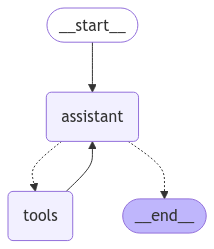

In [81]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph import MessagesState

# Node
def assistant(state: MessagesState) -> MessagesState:
  # ek assistant bnaya jis ki state ma sub record moujod ha uski type msgstate ha jo state k under tmam msg ki state ha
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
  #  ek msgs ki list ha uska under hum is tool ko call karaga phr sysmsg or state k under jo b new prompt aiga wo msg ma pass hojaiga
# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# first assistant call then tool or tools hamara pas teen ha add,divide, multiply jo (tools) k variable ma availabel ha

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",tools_condition,)
    # Agar assistant ka latest message (result) ek tool call ho -> to tools_condition usse tools ki taraf route karega.
    # Agar assistant ka latest message (result) ek tool call nahi hai -> to tools_condition usse END ki taraf route karega.

builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [82]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (1b4fd81c-242c-4042-86d3-9c9e53c61823)
 Call ID: 1b4fd81c-242c-4042-86d3-9c9e53c61823
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


Now, let's multiply by 2!

In [83]:
# messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": "Multiply that by 2."})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

What would you like me to multiply by 2?  I need a number to perform this operation.


We don't retain memory of 7 from our initial chat!
<!-- note -->
ub tk humna memory ka use ni kya islya ai porana record memorize ni krrha ha.

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph ek checkpointer use kar sakta hai jo har step ke baad graph state ko automatically save kare.

Yeh built-in persistence layer humein memory deti hai, jo LangGraph ko pichli state update se dobara shuru karne ki ijazat deti hai.

Sabse asaan checkpointers me se ek MemorySaver hai, jo graph state ke liye ek in-memory key-value store ka kaam karta hai.

Humein sirf graph ko ek checkpointer ke sath compile karna hota hai, aur hamara graph memory ke sath kaam karne lagta hai!

# Transient State vs. Steady State

Computing aur system behavior mein, hum aksar do states encounter karte hain: transient aur steady.
# Transient State:

Transient State:
Definition: Transient state refers to the moments right after a change occurs. It's a temporary, dynamic condition.
# Example:
 When you start a new chat session, your memory is transient—you're catching up, refreshing your context, and getting back into the conversation groove.
# Steady State:

# Definition:
 Steady state ek stable aur predictable condition ko represent karta hai. Yeh tab hota hai jab system apne equilibrium (balance) mein pohanch jata hai.
# Example:
 Jab humari chat aage barhti hai aur hum pichli conversations ki details yaad karte hain, to hum steady state ki taraf barhte hain.

Yaad Rakhein: Ek single chat session (ya graph execution) mein hum dono states—transient aur steady—ka experience karte hain. Har interaction hamari overall understanding mein contribute karta hai.


In [84]:
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

# Checkpointer:
Definition: Ek tool jo LangGraph ki har step ki state save karta hai.
Example: Agar graph halfway complete ho aur system band ho jaye, checkpointer saved state se dobara shuru karega.
# MemorySaver:
Definition: Ek in-memory key-value store jo graph state ko save karta hai.
Example: Har step ke baad graph ka current state MemorySaver mein save hota hai, taake dobara wohi state retrieve ki ja sake
Jab hum memory use karte hain, humein ek thread_id specify karna hota hai.

Thread_id ka kaam:
Yeh memory location ko define karta hai jahan graph states ka collection store hoga.
Cartoon Explanation:
Checkpointer ka kaam:
Graph ke har step par state ko save karna.
Checkpoints ka store hona:
Yeh states ek specific thread mein save hoti hain.
Thread ka future access:
Humein thread_id ke zariye woh thread aur uski saved states ko access karne ki facility milti hai.
Example: Agar aap ek graph ko pause karte hain, thread_id se dobara usi state ko resume kar sakte hain.








When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our memory location of graph states collection.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)

![state.png](https://github.com/panaversity/learn-agentic-ai-fundamentals/blob/main/03_langchain_ecosystem/langgraph/course-notebooks/module-1/image.png)


In [85]:
"'/content/Screenshot 2024-11-16 131558.png', '/content/Screenshot 2024-11-16 131610.png', 'plz show proper this images in png form'"

"'/content/Screenshot 2024-11-16 131558.png', '/content/Screenshot 2024-11-16 131610.png', 'plz show proper this images in png form'"

In [86]:
# Specify a thread
config1 = {"configurable": {"thread_id": "1"}}


In [87]:


# Specify an input
# messages = [HumanMessage(content="Add 3 and 4.")]
# situational

# Run
messages = react_graph_memory.invoke({"messages": "Add 3 and 4."},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (43818e59-9d62-4cbc-aa30-c5b3e07b3d1a)
 Call ID: 43818e59-9d62-4cbc-aa30-c5b3e07b3d1a
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [88]:
# messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages":"Multiply that by 2."}, config1)
for m in messages['messages']:
    m.pretty_print()
    # parallel

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (43818e59-9d62-4cbc-aa30-c5b3e07b3d1a)
 Call ID: 43818e59-9d62-4cbc-aa30-c5b3e07b3d1a
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (418c79dc-b9e1-4479-b8cb-42bb882ab046)
 Call ID: 418c79dc-b9e1-4479-b8cb-42bb882ab046
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message =====================

every parallel tool calling is called supersteps of checkpointer snapshot....parallel mean 4 + 5 then outpput and next 4* 4 =16 now 9 + 16 = 24 is parallel steps and also called super step ..this is checkpointer .snapshot

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.